In [1]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- The fact that so many lenses are able to contribute to the deflection might be a relic of using point like lenses.  Try making them finite size, i.e. look into Gaussian lenses from Sid+Ken et alo's PS paper. (they are somewhere between pointlike and fluffy sub-halos)
- microlensing are good at point like objects

In [2]:
%autoreload

import numpy as np
import pickle

from scipy.interpolate import interp1d
import scipy.stats as stat

# Astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.coordinates as coord

# lenstools
import lenstools as lt

# Convenient variables
pi   = np.pi
norm = np.linalg.norm
mult = np.matmul
dot  = np.dot

Questions:
- We can find the circular motion of the sun around the Milky Way by following the references in `coord.Galactocentric().frame_attribute_references`. But the sun isn't the only star on a circular path.  Shouldn't all stars have circular paths?  And doesn't that affect our ability to see multiblips?  We should start somewhere easier.
- Doesn't the observed flux of the star also increase due to lensing (i.e. focusing)? Shouldn't that be taken into account?
- How does Gaia determine the distance?  Angular position makes sense, and so I know how a lens would distort the apparent angular position.  But what about apparent vs. observed distance?
- What about multiple deflections?  Three lenses somewhat along the line of sight -> confusing geometry of the observed source.
- For a $10^8 M_\odot$ compact source, the source can have an impact parameter of $3 Mpc$ and produce a $\mu as$ deflection.  Seems suspiciously sensitive.... however based on Ken's paper, it's true.
- However, the above seems to tell me that the approximations going into Ken's lens equation (small angle, etc.) aren't valid anymore.  I've found \href[Virbhadra+Ellis](https://arxiv.org/pdf/astro-ph/9904193.pdf) for the full equation.
- If such far away objects can deflect source light significantly, and there are many such objects throughout the halo, shouldn't we use an equation that involves many lenses?

TODO:
- Figure out feasibility (what will GAIA measure?  What are our capabilities? Is this a good idea, or a solution in search of a problem?)
- What should we look for: sub-haloes, exotic compact objects (Diss DM Rouven1812), minihaloes (erickcek), PBHs

Two possibilities:
- $\textbf{Conceptually simple}$: source (6d position, intrinsic props?), lens (6d position, intrinsic params), properties of Gaia?
- $\textbf{Technically simple}$:  What are the dof's? Cut them down with spherical symmetry. source (distance away, perp velocity), lens (distance, impact parameter, enclosed mass, perp velocity)


Progression:
1. Assume a simple reference frame where the observer is at the origin, the orientation is fixed and arbitrary, and the sources and lenses move in straight lines.
2. Add the parallax effect.
3. Put the origin in the Galactic center, sample lenses and sources wrt the center, put the observer at its correct position (8kpc away). Assume no rotations, just a stationary observer and linear motions of lenses and sources. The linear motions can be given by the Jeans Equation with simple approximations.
4. Put in coherent motions of lenses, sources, and observer around the center.

# 1. Simple Frame, Simple Distributions

## Initialization

In [3]:
# Number of sources, lenses
N_s, N_l = 20, 10

# compact object mass, in solar masses
M_co = 1e7 * u.M_sun

# Average Distance of source according to Gaia DR2
R_s  = 600 * u.pc


In [4]:
%autoreload

observer = lt.Observer()
lens, src = lt.sample('relative', scale=np.array([4,4,.1])*u.kpc, observer=observer)
lens.M = M_co

# (4*lt.G_N*lens.M/lt.c**2 / lt.mu_as).to(u.pc)

n = (lens.x-observer.x)/norm(lens.x-observer.x)
# print(
#     'Dl: ',  dot(n,lens.x), '\n',
#     'Ds: ',  dot(n,src.x), '\n',
#     '|b|: ', norm(src.x - dot(n,src.x)*n),
#     sep=''
# )

print(
    '\nWhat the observer sees without a lens (\\theta, \phi): \n\t', 
    observer.observe(src), 
    sep=''
)

print(
    '\n\nDeviation induced by lens',
    '\nKen\'s formula: \n\t', 
    (observer.observe(src, lens, method='fully_approximate') - observer.observe(src)).to(u.mas), 
    sep=''
)

# print(
#     '\nquadratic formula: \n\t\Delta \\theta+:', 
#     observer.observe(src, lens, method='quadratic')[0] - observer.observe(src), 
#     '\n\t\Delta \\theta-:',
#     observer.observe(src, lens, method='quadratic')[1] - observer.observe(src), 
#     sep=''
# )

print(
    '\nquadratic formula:\n\t', 
    (observer.observe(src, lens, method='quadratic') - observer.observe(src)).to(u.mas), 
    sep=''
)


What the observer sees without a lens (\theta, \phi): 
	[ 1.01675008 -0.25306145] rad


Deviation induced by lens
Ken's formula: 
	[ 2.45820798 -0.56675307] mas

quadratic formula:
	[ 4.52671389 -1.0436582 ] mas


In [5]:
(1e9*u.km/u.s).to(u.kpc/u.yr)

<Quantity 1.02271217 kpc / yr>

In [81]:
%autoreload
# lens.M*=10
lens_tmp = lens.copy()
src_tmp = src.copy()

fac=1
fac2=5

lens_tmp.v = np.array([0,0,0]) * u.km/u.s
lens_tmp.x = np.array([0,0,1]) * u.kpc
lens_tmp.M = 1e6 * u.M_sun

src_tmp.v = np.array([1,0,0]) * 1e6*fac*fac2 * u.km/u.s
src_tmp.x = np.array([-.01*fac2,.01,2]) * u.kpc

# src_tmp.time_evolve(dt=-25*0.1*u.yr)
# lens_tmp.time_evolve(dt=-25*0.1*u.yr)

tmp1, tmp2 = observer.observe(src_tmp, lens_tmp, method='fully_approximate', N=100, dt=0.2/fac * u.yr)

# tmp1, tmp2 = observer.observe(src_tmp, lens_tmp, method='quadratic', N=100, dt=0.2/fac * u.yr)

t_vec = np.arange(0,2/fac,.02/fac)

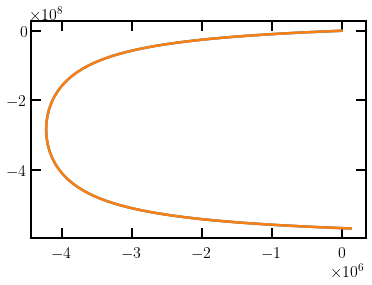

In [78]:
plt.figure()
plt.plot(tmp1[:,0], tmp1[:,1])
plt.plot(tmp2[:,0], tmp2[:,1])


We should see how quickly this deviation becomes visible by eye as the impact parameter goes to zero.

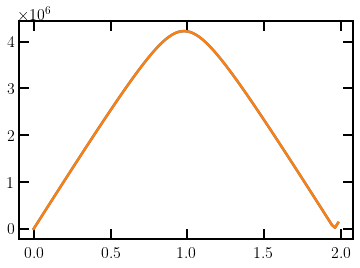

In [79]:
# plt.plot(t_vec, np.abs(tmp2[:,0]-tmp1[:,0]))
plt.plot(t_vec, np.abs(tmp2[:,0]))
plt.plot(t_vec, np.abs(tmp1[:,0]))
# plt.plot(t_vec, np.abs(tmp2[:,1]-tmp1[:,1]))

## Cross-Checks

In [35]:
## Without a lens, I get the phi and theta of a source to machine precision

for i in np.arange(10):
    lens, source = lt.sample('relative', scale=8*u.kpc, observer=observer)
    r = norm(source.x)
    theta, phi = observer.observe(source)
    print(norm(source.x.value - np.array(
        [(r*np.sin(theta)*np.cos(phi)).value, 
        (r*np.sin(theta)*np.sin(phi)).value, 
        (r*np.cos(theta)).value])
    ))

0.0
1.2560739669470201e-15
2.175583928816829e-15
1.0877919644084146e-15
9.930136612989092e-16
2.808666774861361e-15
0.0
1.9984014443252818e-15
2.085919684541963e-15
9.930136612989092e-16


# 3. Distributions of Sources and Lenses

In [ ]:
lenses = lt.Lenses(
    x = lt.sample_position(N[1], lt.R), 
    v = stat.norm.rvs(0, lt.v_esc, [N[1],3]),
    M = M_co
)

sources = lt.Sources(
    x = lt.sample_position(N[1], lt.R), 
    v = stat.norm.rvs(0, lt.v_esc, [N[1],3])
)

# Convert to Sky Coordinates

In [9]:
scnow = SkyCoord(
    x=(x_srcs[:,0]*u.km).to(u.kpc),
    y=(x_srcs[:,1]*u.km).to(u.kpc),
    z=(x_srcs[:,2]*u.km).to(u.kpc),
    frame='galactocentric'
)
scnow = scnow.transform_to(coord.ICRS)

In [28]:
#!!! Pretending that the Earth's orbit is a circle with radius 1 AU
amplitude = 1*u.kpc
repr0 = scnow.barycentrictrueecliptic.cartesian

def eclcart_to_spherical1(rep):
    return rep.represent_as(coord.SphericalRepresentation)

#scatkwargs = dict(s=mag_to_size(mag), alpha=.9, c=scnow.distance, cmap=darker_vidiris)
scatkwargs = dict(alpha=.9)

def animfunc(phase, eclcart_to_spherical, ax, ylims=(0, 90)):
    drepr = coord.CartesianRepresentation([np.cos(phase),np.sin(phase),0]*amplitude)
    rep = repr0 + drepr
    srep = eclcart_to_spherical(rep)
    
    ax.cla()
    # ax.set_title(f'Center={centerstr}, Earth semimajor axis={amplitude}')
    ax.scatter(srep.lon.rad, 90-srep.lat.deg, **scatkwargs)
    ax.set_ylim(*ylims)
    ax.set_yticks(np.linspace(*ax.get_ylim(), 5)[1:])
    ax.set_yticklabels(['{}'.format(int(90-yl)) for yl in ax.get_yticks()])
    ax.grid(alpha=.5)

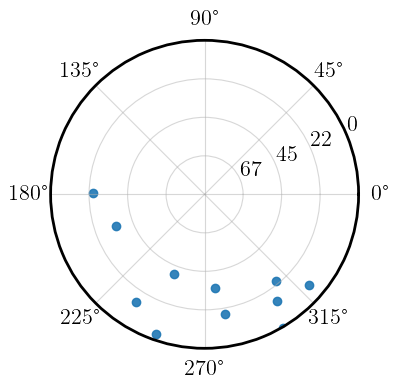

In [29]:
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(projection='polar')


animfunc(0, eclcart_to_spherical1, ax)

In [98]:
# repr0 = scnow.barycentrictrueecliptic.cartesian
repr0 = scnow.icrs.cartesian

phase=0
drepr = coord.CartesianRepresentation([np.cos(phase),np.sin(phase),0]*amplitude)
rep = repr0 + drepr
# rep.represent_as(coord.ICRS)

In [99]:
rep

<CartesianRepresentation (x, y, z) in kpc
    [(-5.88491096,  -3.17144999,   3.26537629),
     (-1.78705735,  -5.03318686,   0.49145424),
     ( 2.12181245,  -4.81548062,  -9.31338091),
     (-1.05714391,   2.24176212,  -3.60568316),
     (-9.94418522,  -8.68866432,  -1.50307338),
     ( 3.7048713 ,  -6.94958579, -10.73358314),
     (-0.3648277 ,  -2.98405263,   1.79430698),
     (-3.13936839,  -6.97368781,  -7.46274514),
     (-9.25288161,  -8.7603972 ,  -6.27116545),
     ( 2.26020559,  -6.61371122,  -7.13838266),
     (-1.65667663, -13.07425287,  -4.58932112),
     ( 7.6833585 ,  -3.68172812,  -2.08089504),
     (-4.68418629, -12.05147278,   2.84192512),
     (-1.95375495,  -4.59401553, -13.32005351),
     (-0.15167927, -14.59132701,  -2.58342049),
     ( 0.04703921, -12.81225564,  -7.54114061),
     (-2.6646762 ,  -3.96574743,  -5.06596959),
     ( 1.05224875,  -3.79933595,   3.73953472),
     ( 2.26879884,  -8.18843645,  -1.38900304),
     (-3.11827705,  -5.19385553,  -7.69231472)

### SkyCoord Practice

In [6]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.coordinates as coord

In [7]:
from astropy.time import Time
c = SkyCoord(l=10*u.degree, b=45*u.degree, distance=100*u.pc,
              pm_l_cosb=34*u.mas/u.yr, pm_b=-117*u.mas/u.yr,
              frame='galactic',
              obstime=Time('1988-12-18 05:11:23.5'))

c = coord.SkyCoord(ra=[158.3122, 24.5] * u.degree,
                    dec=[-17.3, 81.52] * u.degree,
                    distance=[11.5, 24.12] * u.kpc)

In [8]:
c

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(158.3122, -17.3 , 11.5 ), ( 24.5   ,  81.52, 24.12)]>

In [9]:
(1e-2*u.mas).to(u.pc, u.parallax())

<Quantity 100000. pc>

In [10]:
(1e-2*u.mas).to

<bound method Quantity.to of <Quantity 0.01 mas>>

In [11]:
c.transform_to(coord.Galactocentric) 

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    [( -9.43489286, -9.40062188, 6.51345359),
     (-21.11044918, 18.76334013, 7.83175149)]>

In [63]:
(u.lightyear/u.au).decompose().scale

63241.077084266275

In [51]:
ra = np.array([10.1,1.1,2.0, 0.2])*u.rad
dec = np.array([1.1, 1.0, 0.02, 0.5])*u.rad
dist = (np.array([100.2,5.5,1.0, 2.2])*u.mas).to(u.pc, u.parallax())

scnow = SkyCoord(ra, dec, distance=dist)
x,y,z = scnow.cartesian.xyz

In [44]:
repr0 = scnow.barycentrictrueecliptic.cartesian

In [46]:
repr0.represent_as(SphericalRepresentation)

<SphericalRepresentation (lon, lat, distance) in (rad, rad, pc)
    [(0.72018533,  0.92671848,    9.98003992),
     (1.26500575,  0.61933823,  181.81818182),
     (2.02965064, -0.35040349, 1000.        ),
     (0.38706697,  0.37956058,  454.54545455)]>

In [16]:
# How can I start in a frame centered at the center of the Milky Way?
sc_srcs = SkyCoord(
    representation_type='cartesian',
    x = x_srcs[:,0],
    y = x_srcs[:,1],
    z = x_srcs[:,2]
)

# GAIA DR2

I am following [this](https://gist.github.com/eteq/02a0065f15da3b3d8c2a9dea146a2a14#file-parallax_gaiadr2-ipynb) code. 

Also, [astroquery](https://astroquery.readthedocs.io/en/v0.3.9/index.html#archives) seems interesting enough to learn more about.

Another way to download data [here](https://www.cosmos.esa.int/web/gaia-users/archive/programmatic-access#command_Sect1).

In [32]:
import numpy as np

from termcolor import cprint

import astropy.units as u
from astropy.io import votable
from astropy.coordinates import SkyCoord, CartesianRepresentation, SphericalRepresentation, matrix_utilities
from astropy.table import Table

from matplotlib import cm, colors, pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from astroquery import gaia
from astroquery.gaia import Gaia as g
from astroquery.utils.tap import TapPlus

In [33]:
using_ari = False
def fix_ari_query(job):
    from urllib.request import urlopen
    from xml import etree

    remtree = etree.ElementTree.parse(urlopen(job.get_remote_location()))

    res_elem = remtree.find('*/{http://www.ivoa.net/xml/UWS/v1.0}result')
    res_url = res_elem.attrib['{http://www.w3.org/1999/xlink}href']
    res_url

    vtab = votable.parse(res_url)

    for fi in vtab.iter_fields_and_params():
        if not isinstance(fi, votable.tree.Field):
            continue #params
        fi.ID = fi.name
    return vtab.get_first_table().to_table()

In [36]:
## Load metadata
tmp = g.load_tables()
print(tmp[0].get_qualified_name())
tds = {t.get_qualified_name():t for t in tmp}
for key in tds.keys():
    if 'source' in key:
        print(key)

# tmp2 = g.load_table('gaiadr2.gaia_source')

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [ ]:
from astroquery.gaia import Gaia as g
import astropy.units as u
from astropy.io import votable
from astropy.coordinates import SkyCoord, CartesianRepresentation, SphericalRepresentation, matrix_utilities
from astropy.table import Table

In [64]:
## Load actual data

pclim = 10*u.kpc
pxlim = pclim.to(u.marcsec, u.parallax())

mag = 10 # 12

qry=f"""
SELECT *
FROM gaiadr2.gaia_source
WHERE parallax >= {pxlim.value} AND phot_g_mean_mag <= {mag}
"""

job = g.launch_job_async(qry)
tab = job.get_results()
len(tab)

# pickle.dump(tab, open('/Users/gregoryridgway/Desktop/AstroML/data/Gaia_DR2', 'wb'))
# pickle.dump(tab, open('/Users/gregoryridgway/Desktop/AstroML/data/Gaia_DR2_10kpc_mag10', 'wb'))

INFO: Query finished. [astroquery.utils.tap.core]


478688

In [336]:
tab

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object
1635721458409799680,Gaia DR2 4038055447710650240,4038055447710650240,1422926548,2015.5,274.4061143187362,0.8484865818441963,-36.76240607839242,0.7699228339052769,19.653809686071373,0.9336287242586353,21.050991,-131.91735165925866,1.5866347182871663,-164.92287295610117,1.4493621781679744,-0.04765288,-0.30638885,-0.20533392,-0.06941658,-0.2043609,0.010371089,-0.30376002,-0.21814625,0.1171404,-0.12497318,114,114,109,5,191.20386,98974.65,3.4410265572801118,3131.561904869388,31,False,0.07572304,2.0456258319976923,0.23699778325590104,-0.20245567,14,9,0.8074792,0,18,False,115,3201722897.2008457,19443470.355373625,164.66829,1.9249064,17,434382474.8477304,12789430.381139927,33.964176,3.7567074,17,1444134724.0162575,31913219.62981784,45.251926,1.8629007,0.5867207,0,1.8938067,1.831801,0.06200564,--,--,0,--,--,--,NOT_AVAILABLE,356.43209109585257,-9.676937844208421,273.6271682533203,-13.378586037363576,101001,4732.6665,3616.0,6756.0,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+4038055447710650240
1635721458409799680,Gaia DR2 5589311357724458368,5589311357724458368,373558530,2015.5,109.28559761663782,0.9067893635565435,-37.097446909729776,0.9344878893445064,3.7974625279057883,1.0619630885874203,3.5758893,-14.637400320746199,1.982978013256365,2.2834

In [205]:
tab = pickle.load(open('/Users/gregoryridgway/Desktop/AstroML/data/Gaia_DR2_10kpc_mag10', 'rb'))

# only need to do the fix described above if the ARI mirror is used
if using_ari:
    tab = fix_ari_query(job)
else:
    # the Gaia server outputs tables with units that aren't parsable.  So we just manually fix some of those here
    tab['pmra'].unit = 'mas / yr'
    tab['pmdec'].unit = 'mas / yr'
    tab['radial_velocity'].unit = 'km / s'

mag = np.array(tab['phot_g_mean_mag'])
scnow = SkyCoord(
    tab['ra'], 
    tab['dec'], 
    distance=(np.array(tab['parallax'])*u.mas).to(u.pc, u.parallax())
)

# Proper Motion

# scpm = SkyCoord(scnow, pm_dec=u.Quantity(tab['pmdec'][msk]),
#     pm_ra_cosdec=u.Quantity(tab['pmra'][msk])*np.cos(scnow.dec))
# scpmecl = scpm.barycentrictrueecliptic
scpmrv = SkyCoord(scnow, pm_dec=u.Quantity(tab['pmdec']),
                       pm_ra_cosdec=u.Quantity(tab['pmra'])*np.cos(scnow.dec),
                       radial_velocity=u.Quantity(tab['radial_velocity'].filled(0))
               )
# scpmrvecl = scpmrv.barycentrictrueecliptic
# max((scpmrv.dec-scpmrv.apply_space_motion(dt=1*u.year).dec).to(u.mas))

In [179]:
(scnow.distance.mean(), scnow.distance.std())

(<Distance 619.2635055 pc>, <Distance 600.40744984 pc>)

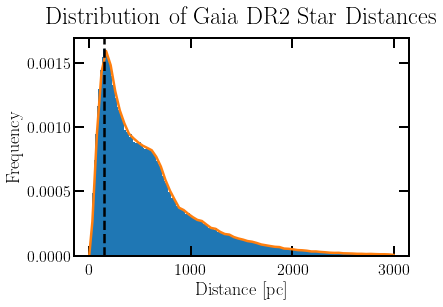

In [196]:
a,b = np.histogram(scnow.distance.value[scnow.distance.value<3000], bins=200, density=True)
x = (b[1:] + b[:-1])/2
b_width = np.diff(b)[0]
plt.bar(x, a, b_width)
plt.xlabel('Distance [pc]')
plt.ylabel('Frequency')
plt.title('Distribution of Gaia DR2 Star Distances')


window = 3
data = [[0,0]]
for i in np.arange(0,len(a),window):
    data.append([b[i+2], np.sum(a[i:i+window])/window])

data = np.array(data)

plt.plot(data[:,0], data[:,1], color='C1')

inv_cdf = interp1d(np.cumsum(data[:,1])*b_width*3, data[:,0], fill_value='extrapolate')

pickle.dump(inv_cdf, open('/Users/gregoryridgway/Desktop/AstroML/data/Gaia_DR2_inv_cdf', 'wb'))

plt.axvline(150, linestyle='--', color='k')

In [136]:
tmp = np.array(list(map(norm,scnow.galactocentric.cartesian.xyz.T.value)))
msk = tmp<6500

# msk = (np.arange(len(scnow))%110 == 0)

mag = mag[msk]
scnow = scnow[msk]

# Archive

Sample from a sphere:

$$
\begin{alignat}{1}
1 &= \frac3{4\pi R^3} \int d^3x \; \theta(R - |x|) \\
&= \int_0^R dr \; \frac{3r^2}{R^3} \int_0^{2\pi} \frac{d\phi}{2\pi} \; \int_{-1}^{1} \frac{d\cos \theta}{2} \\
&= \int_0^1 d\left( \frac{r}{R}\right)^3 \int_0^{2\pi} \frac{d\phi}{2\pi} \; \int_{-1}^{1} \frac{d\mu}{2}
\end{alignat}
$$

where $\mu = \cos(\theta)$.

$$ \Delta \theta = -\left( 1- \frac{D_l}{D_s} \right) \frac{4G_N M(b_{ls})}{b_{ls}} \hat{b}_{ls} $$

In [ ]:
## Variables for Lensing formula

# Gaia's origin
icrs_origin = coord.SkyCoord(ra=0 * u.deg, dec=0 * u.deg, distance=0 * u.kpc)
x_0 = (
    icrs_origin.transform_to(coord.Galactocentric).cartesian.xyz/u.km
).decompose().value

# lens distance from observer
D_l = np.array(list(map(norm, x_lens-x_0)))

# Directions to lens
def normalize(vec):
    return vec/norm(vec)

direcs = np.array(list(map(normalize, x_lens-x_0)))

# matrix of source distances along lens lines of sights
#   row:    lens
#   column: source

D_s = mult(direcs, (x_srcs-x_0).T)


# Matrix of impact parameters
b = np.zeros((x_lens.shape[0], x_srcs.shape[0]))

for l, n_l in enumerate(direcs):
    for s, x_s in enumerate(x_srcs-x_0):
        b_vec = x_s - np.dot(n_l, x_s) * n_l
        b[l][s] = norm(b_vec)

# Consistency Check: right triangle for any source-lens pair
# for l in np.arange(direcs.shape[0]):
#     print((b[l][s]**2 + D_s[l][s]**2)/norm(x_srcs[s])**2)


# Note: If we used a halo we'd compute M(b) for a src-lens pair here.

In [ ]:
# Matrix of Deflections
dTheta = np.zeros((x_lens.shape[0], x_srcs.shape[0]))

for l, n_l in enumerate(direcs):
    for s, src in enumerate(x_srcs):

        # The source needs to be further from the lens
        # This also accounts for sources being on the wrong side of the lens
        if D_s[l][s] > D_l[l]:

            # in micro arcseconds
            dTheta[l][s] = -(1-D_l[l]/D_s[l][s]) * 4*G_N * M_co/b[l][s] / c_light**2 / mu_as

In [ ]:
from astropy.time import Time

icrs_origin = coord.SkyCoord(
    ra=.00001 * u.deg, dec=.00001 * u.deg, distance=1e-12 * u.kpc,
    pm_ra_cosdec=0*u.mas/u.yr, pm_dec=0*u.mas/u.yr, radial_velocity = 0 * u.km/u.yr,
    obstime=Time('1988-12-18 05:11:23.5')
)

# (icrs_origin.transform_to(coord.Galactocentric).cartesian.xyz/u.kpc).decompose().value
# coord.Galactocentric().frame_attribute_references

In [ ]:
%autoreload
observer = lt.Observer()

# Import the inverse cdf of the distances from Gaia DR2 sources
inv_cdf = pickle.load(open('/Users/gregoryridgway/Desktop/AstroML/data/Gaia_DR2_inv_cdf', 'rb'))

sources = lt.Sources(
    x = lt.sample(N_s, scale=1*u.pc, method='custom_sphere', inv_cdf=inv_cdf),
    v = lt.sample(N_s, scale=u.km/u.s, method='normal')
)

# Now pick a source and make random lenses wrt to it.



In [ ]:
%autoreload
observer = lt.Observer()

lenses = lt.Lenses(
    x = lt.sample('uniform_sphere', N_l, scale=10*u.kpc),
    v = lt.sample('normal', N_l, scale=100*u.km/u.s),
    M = M_co
)

# Now pick a lens and make random sources wrt to it.